Simple DNN with feature processing and dependent results

In [1]:
import ktrain
import pandas as pd
from ktrain import tabular
import numpy as np
import pandas   as pd
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def get_model(a,project):
    # load the model
    df = pd.read_csv(f'../data/{project}_combined.csv')
    # drop all rows in df
    df = df.drop(df.index)
    print(df.shape)
    for p,u in a.items():
        if p == project:
            continue
        df1 = pd.read_csv(f'../data/{p}_combined.csv')
        df = pd.concat([df,df1])
    df = df.drop(columns=['comments','content'],axis=1)
    # Count the number of rows in the "not_smell" class
    # not_smell_count = (df['catagory'] == 'not_smell').sum()

    # # Calculate the number of rows to drop (one-third of the count)
    # rows_to_drop = not_smell_count // 3

    # # Filter the DataFrame to exclude one-third of the "not_smell" class
    # filtered_smell = df[df['catagory'] == 'not_smeel'].sample(frac=(1/3))  # Selecting 2/3 of 'not_smell' instances
    # # print(filtered_smell.shape)
    
    # defalut_smell = df[df['catagory'] != 'not_smeel']
    # print(defalut_smell.shape)
    # df = pd.concat([filtered_smell, defalut_smell])
    
    train_df = shuffle(df)
    test_df = pd.read_csv(f'../data/{project}_combined.csv')
    test_df = test_df.drop(columns=['comments','content'],axis=1)
    # df = df.sample(frac=1).reset_index(drop=True)
    
    # np.random.seed(42)
    # p = 0.1 # 10% for test set
    # prop = 1-p
    # temp_df = df.copy()
    # msk = np.random.rand(len(temp_df)) < prop
    # train_df = temp_df[msk]
    # test_df = temp_df[~msk]
    # print(train_df["label"].value_counts())
    # print(test_df["label"].value_counts())
    test_df['index'] = test_df.index
    train_df['index'] = train_df.index  
    return train_df, test_df

In [3]:
def get_lean(train_df,test_df):
    print(test_df.iloc[1])
    trn,val,preproc = tabular.tabular_from_df(train_df, label_columns=['catagory'], random_state=42)
    model  = tabular.tabular_classifier(name='mlp',train_data=trn,multilabel=True)
    learner = ktrain.get_learner(model,train_data=trn,val_data=val,batch_size=32)
    # learner.lr_find(show_plot=True, max_epochs=5)
    data = {"get":0,"is":1,"not_LA":2,"set":3}
    learner.fit_onecycle(5e-3, 1)
    print(learner.evaluate(val, class_names=preproc.get_classes()))
    predictor = ktrain.get_predictor(learner.model, preproc)


    preds = predictor.predict(test_df, return_proba=True)
    try:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for class_name, class_idx in data.items():
            y_true_class = (test_df['catagory'] == class_name).astype(int)
            y_score_class = preds[:, class_idx]
            fpr[class_name], tpr[class_name], _ = roc_curve(y_true_class, y_score_class)
            roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
            
            
        # Plot ROC curve for each class
        plt.figure()
        for class_name, class_idx in data.items():
            plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (AUC = {roc_auc[class_name]:0.2f}) for {class_name}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        # # Calculate AUC for each class

        # auc_scores = []
        # for class_name, class_idx in data.items():  # Iterate over each class
        #     y_true_class = (test_df['catagory'] == class_name).astype(int)  # Convert true labels to binary for the current class
        #     y_pred_class = preds[:, class_idx]  # Predicted probabilities for the current class
            
        #     print(f'Class {class_name}:')
        #     print('y_true_class:', y_true_class)
        #     print('y_pred_class:', y_pred_class)
            
        #     auc_score = roc_auc_score(y_true_class, y_pred_class)  # Compute ROC AUC
        #     auc_scores.append(auc_score)
        #     print(f'AUC for class {class_name}: {auc_score}')

        # # Overall AUC can also be computed by averaging the AUC scores for each class
        # overall_auc = np.mean(auc_scores)
        # print(f'Overall AUC: {overall_auc}')
        # # Calculate MCC for each class
        # mcc_scores = []
        # for class_name, class_idx in data.items():  # Iterate over each class
        #     y_true_class = (test_df['catagory'] == class_name).astype(int)  # True labels for the current class
        #     y_pred_class = np.argmax(preds, axis=1)  # Predicted labels for the current class
            
        #     print(f'Class {class_name}:')
        #     print('y_true_class:', y_true_class.shape)
        #     print('y_pred_class:', y_pred_class.shape)
            
        #     # Filter y_pred_class to match the same samples as y_true_class
        #     y_pred_class_filtered = y_pred_class[test_df['catagory'] == class_name]
        #     print(f"y_pred_class_filtered: {y_pred_class_filtered.shape}")
        #     mcc_score = matthews_corrcoef(y_true_class, y_pred_class)  # Compute MCC
        #     mcc_scores.append(mcc_score)
        #     print(f'MCC for class {class_name}: {mcc_score}')

        # # Overall MCC can also be computed by averaging the MCC scores for each class
        # overall_mcc = np.mean(mcc_scores)
        # print(f'Overall MCC: {overall_mcc}')
        # print(test_df.iloc[2])
        # data = {"get":0,"is":1,"not_LA":2,"set":3}
        # print("predict output is here")
        # pred = predictor.predict(test_df[1:2])
        # print(test_df.iloc[1])
        # # print(f"the prediction is {pred[0]} this")
        # print()
        # print()
        predictor.explain(test_df,row_num=1,class_id=data[pred[0]])
    except ValueError:
        print(f'ValueError {ValueError}')
    
    return predictor

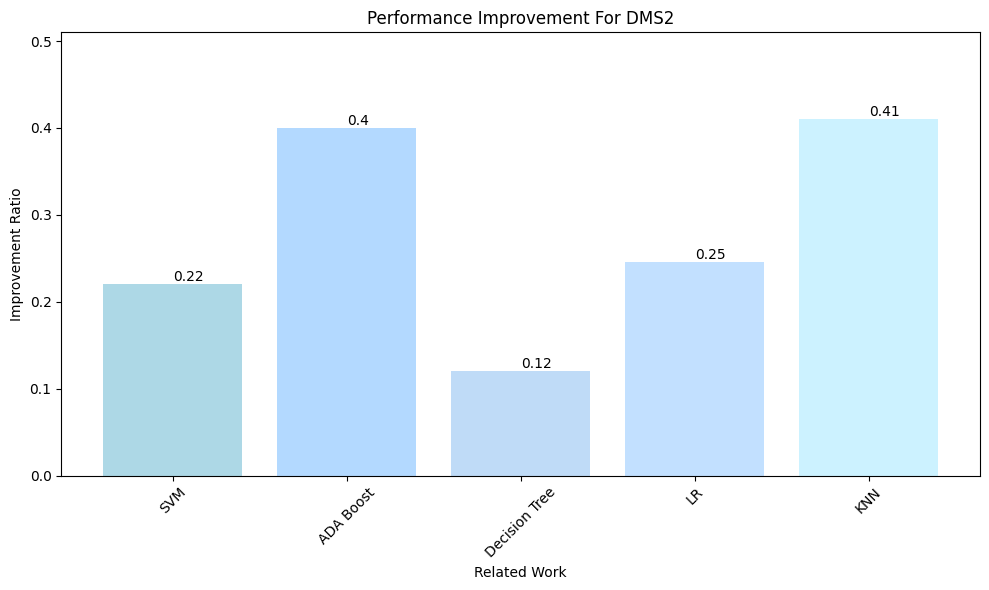

In [10]:
import matplotlib.pyplot as plt

# Values provided by the user
# .362,.359, .0012, .55, .638

# 2.14, 1.635, 1.678, 1.317, 1.27

# .718, 1.4, .44, 1.2, 1.26

# .22, .40, .12,.246, .410

performance_improvement = [.22, .40, .12,.246, .410]
methods = ['SVM','ADA Boost', 'Decision Tree',  'LR','KNN']

# Creating the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, performance_improvement, color=['#add8e6', '#b3d9ff', '#bfdbf7', '#c2e0ff', '#ccf2ff'])

# Adding titles and labels
plt.title('Performance Improvement For DMS2')
plt.xlabel('Related Work')
plt.ylabel('Improvement Ratio')
plt.xticks(rotation=45)
plt.ylim(0, max(performance_improvement) + 0.1)  # Adding some space above the highest bar

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.show()


In [4]:
def model_save(predictor,test_df,output_file):

    print()
    print()
    model_path = f'model/{output_file}_features_model'
    print(model_path)
    print()
    print()
    predictor.save(model_path)
    reloaded_predictor = ktrain.load_predictor(model_path)
    reloaded_predictor.predict(test_df)[:5]

the project is buildship
(0, 8)
access_modifier                  public
return_type        SignedEncryptedParts
method_name              getSignedParts
parameters                          NaN
returns            return signedParts; 
catagory                         not_LA
index                                 1
Name: 1, dtype: object
processing train: 142216 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
63583  0.0  0.0     1.0  0.0
5983   1.0  0.0     0.0  0.0
83504  0.0  1.0     0.0  0.0
19957  0.0  0.0     0.0  1.0
82973  1.0  0.0     0.0  0.0
processing test: 15637 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
5658   1.0  0.0     0.0  0.0
13200  0.0  1.0     0.0  0.0
6876   0.0  0.0     0.0  1.0
3683   0.0  0.0     1.0  0.0
1765   0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...
489/489 [==============================] - 1s 2ms/step
              precision    

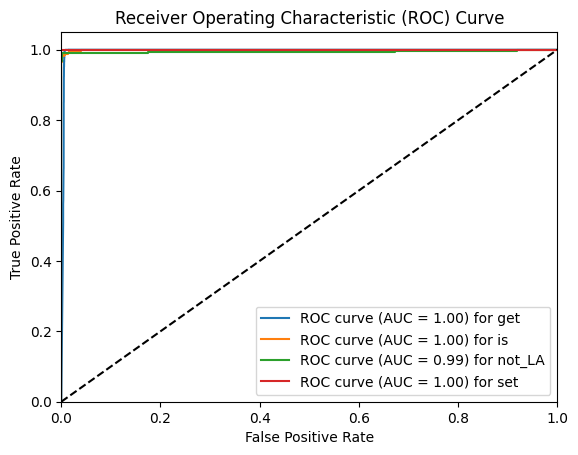

Class get:
y_true_class: 0        0
1        0
2        0
3        0
4        1
        ..
10185    0
10186    0
10187    0
10188    0
10189    0
Name: catagory, Length: 10190, dtype: int64
y_pred_class: [2.2714705e-08 5.6698504e-09 1.1486811e-08 ... 7.3401396e-09 1.3651411e-08
 3.9780018e-14]
AUC for class get: 0.9966795338855987
Class is:
y_true_class: 0        0
1        0
2        0
3        0
4        0
        ..
10185    0
10186    0
10187    0
10188    0
10189    0
Name: catagory, Length: 10190, dtype: int64
y_pred_class: [6.1006244e-06 1.1591794e-06 1.6502845e-08 ... 7.2393053e-10 2.1596148e-07
 2.0833118e-06]
AUC for class is: 0.9995878739003268
Class not_LA:
y_true_class: 0        1
1        1
2        1
3        0
4        0
        ..
10185    1
10186    1
10187    1
10188    1
10189    1
Name: catagory, Length: 10190, dtype: int64
y_pred_class: [0.9999931  0.9999988  1.         ... 1.         0.99999976 0.999998  ]
AUC for class not_LA: 0.9942878145578367
Class set:
y_tru

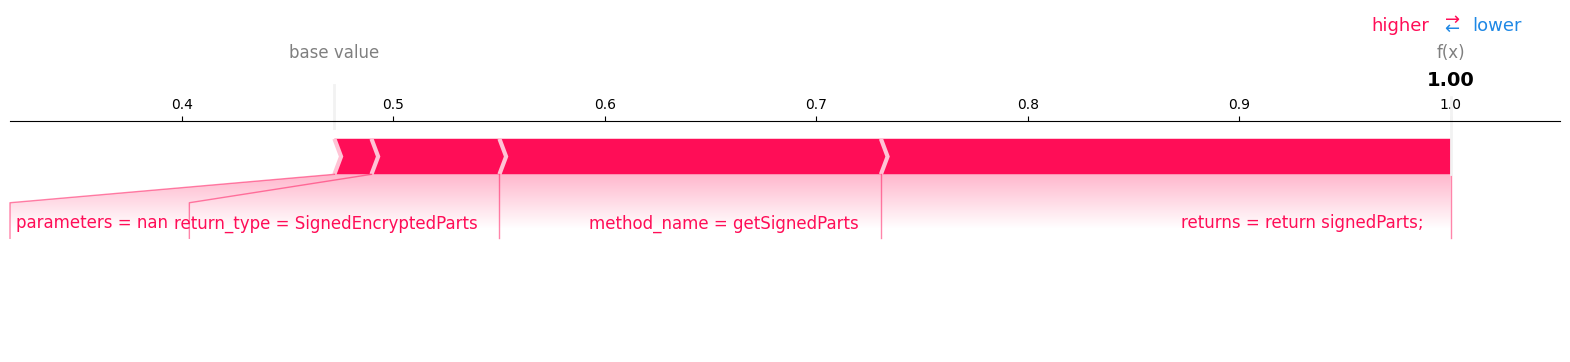



model/buildship_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is eclips-collections
(0, 8)
access_modifier            public
return_type                  void
method_name        testNestedCall
parameters                    NaN
returns                       NaN
catagory                       is
index                           1
Name: 1, dtype: object
processing train: 147083 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
34330  1.0  0.0     0.0  0.0
93150  0.0  0.0     0.0  1.0
6279   0.0  0.0     1.0  0.0
36576  1.0  0.0     0.0  0.0
67816  0.0  0.0     1.0  0.0
processing test: 16186 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
54494  0.0  0.0     1.0  0.0
2625   1.0  0.0     0.0  0.0
14589  0.0  0.0     0.0  1.0
71516  1.0  0.0     0.0  0.0
7826   0.0  1.0     0.0  0.0
Is Multi-Label? False
don

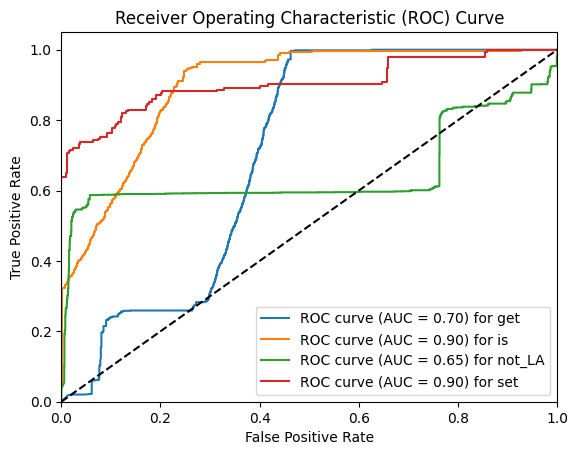

Class get:
y_true_class: 0       1
1       0
2       0
3       0
4       0
       ..
4769    0
4770    0
4771    1
4772    1
4773    1
Name: catagory, Length: 4774, dtype: int64
y_pred_class: [0.6555955  0.6555951  0.98942417 ... 0.99986446 0.65357876 0.3709371 ]
AUC for class get: 0.700674048915964
Class is:
y_true_class: 0       0
1       1
2       1
3       0
4       0
       ..
4769    1
4770    0
4771    0
4772    0
4773    0
Name: catagory, Length: 4774, dtype: int64
y_pred_class: [3.3867666e-01 3.3867720e-01 1.0359952e-02 ... 1.3345867e-04 3.4154084e-01
 6.2792414e-01]
AUC for class is: 0.8968614738504097
Class not_LA:
y_true_class: 0       0
1       0
2       0
3       1
4       1
       ..
4769    0
4770    1
4771    0
4772    0
4773    0
Name: catagory, Length: 4774, dtype: int64
y_pred_class: [5.7186824e-03 5.7184719e-03 2.1598542e-04 ... 1.9729689e-06 4.8730611e-03
 1.1365282e-03]
AUC for class not_LA: 0.649218568991301
Class set:
y_true_class: 0       0
1       0
2       0

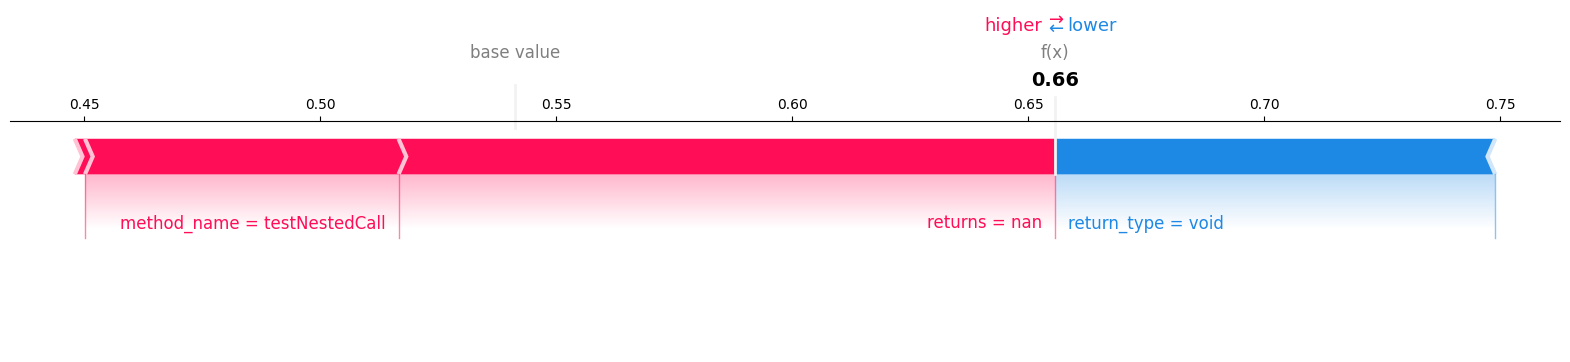



model/eclips-collections_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  1.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is jifa
(0, 8)
access_modifier              public
return_type                    void
method_name        getCauseInterval
parameters                      NaN
returns                         NaN
catagory                        get
index                             1
Name: 1, dtype: object
processing train: 150763 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
24201  0.0  1.0     0.0  0.0
100    0.0  0.0     1.0  0.0
8838   1.0  0.0     0.0  0.0
18842  0.0  0.0     1.0  0.0
33506  1.0  0.0     0.0  0.0
processing test: 16601 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9445   1.0  0.0     0.0  0.0
5953   0.0  0.0     1.0  0.0
83391  0.0  0.0     1.0  0.0
73729  0.0  1.0     0.0  0.0
77488  0.0  0.0     1.0  0.0
Is Multi-Label? False
don

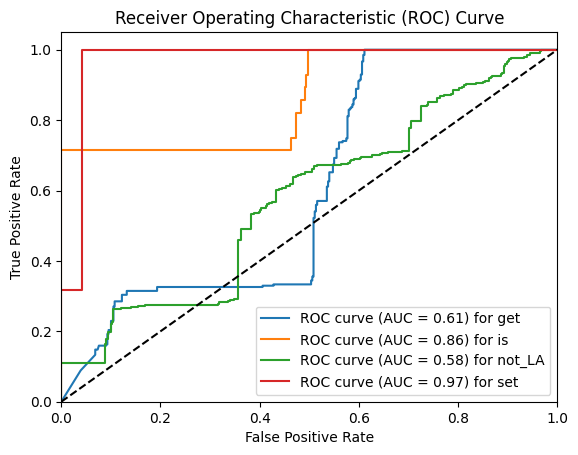

Class get:
y_true_class: 0      1
1      1
2      1
3      1
4      1
      ..
674    0
675    1
676    1
677    1
678    1
Name: catagory, Length: 679, dtype: int64
y_pred_class: [9.9999952e-01 5.4902697e-01 5.4902524e-01 9.9999559e-01 5.4902172e-01
 5.4901999e-01 5.4901826e-01 5.4901654e-01 5.4901481e-01 5.9319937e-06
 5.4901129e-01 7.8134871e-01 4.9655351e-09 7.8134799e-01 9.9876523e-01
 9.5052224e-01 9.9999475e-01 9.9067843e-01 9.6949571e-01 9.3340200e-01
 7.7943797e-03 5.4899216e-01 3.7481911e-07 5.4898870e-01 5.4898697e-01
 5.4898518e-01 9.9999475e-01 5.3310614e-02 7.8134161e-01 9.0276104e-01
 9.3340284e-01 5.4897475e-01 7.8133994e-01 9.2470729e-01 9.9999332e-01
 6.9197017e-01 7.8133827e-01 1.8503475e-11 6.9196796e-01 9.0275425e-01
 7.6390231e-01 9.9995863e-01 9.9962604e-01 9.9999774e-01 5.4895216e-01
 9.9999928e-01 9.9999893e-01 5.4894692e-01 9.7147930e-01 5.4894346e-01
 9.9164456e-01 9.3340451e-01 1.4353110e-04 7.8133118e-01 9.7147781e-01
 9.2468649e-01 3.8209871e-09 9.9068040e

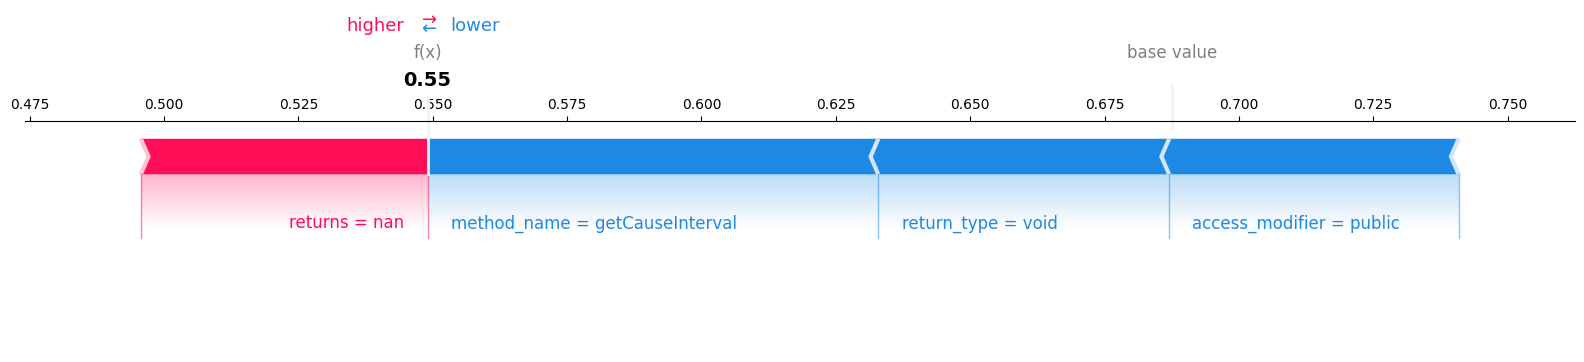



model/jifa_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
the project is jkube
(0, 8)
access_modifier                                              private
return_type                                              ServicePort
method_name                                extractPortsFromImageSpec
parameters         String imageName, String portSpec, ServicePort...
returns            return null; return updateMissingTargetPort(po...
catagory                                                      not_LA
index                                                              1
Name: 1, dtype: object
processing train: 148810 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
67156  0.0  1.0     0.0  0.0
7420   0.0  0.0     0.0  1.0
18113  0.0  0.0     0.0  1.0
77585  0.0  0.0     1.0  0.0
12015  0.0  0.0     1.0  0.0
processing test: 16365 rows x 7 column

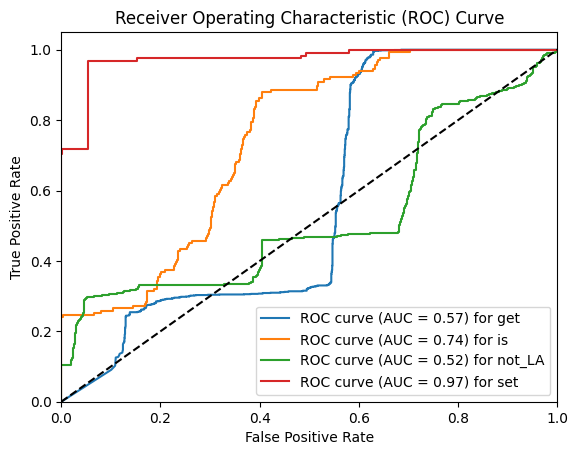

Class get:
y_true_class: 0       0
1       0
2       1
3       0
4       1
       ..
2863    1
2864    1
2865    1
2866    0
2867    0
Name: catagory, Length: 2868, dtype: int64
y_pred_class: [0.9966414  0.98710734 0.5338415  ... 0.52801454 0.00721934 0.99483114]
AUC for class get: 0.5713401145305033
Class is:
y_true_class: 0       0
1       0
2       0
3       0
4       0
       ..
2863    0
2864    0
2865    0
2866    0
2867    0
Name: catagory, Length: 2868, dtype: int64
y_pred_class: [0.00219803 0.0038383  0.46434572 ... 0.47045034 0.08428968 0.00307736]
AUC for class is: 0.740582611720011
Class not_LA:
y_true_class: 0       1
1       1
2       0
3       0
4       0
       ..
2863    0
2864    0
2865    0
2866    1
2867    1
Name: catagory, Length: 2868, dtype: int64
y_pred_class: [0.00116054 0.00904904 0.00177717 ... 0.00150429 0.9067294  0.00209153]
AUC for class not_LA: 0.5244379367136718
Class set:
y_true_class: 0       0
1       0
2       0
3       1
4       0
       ..
2863  

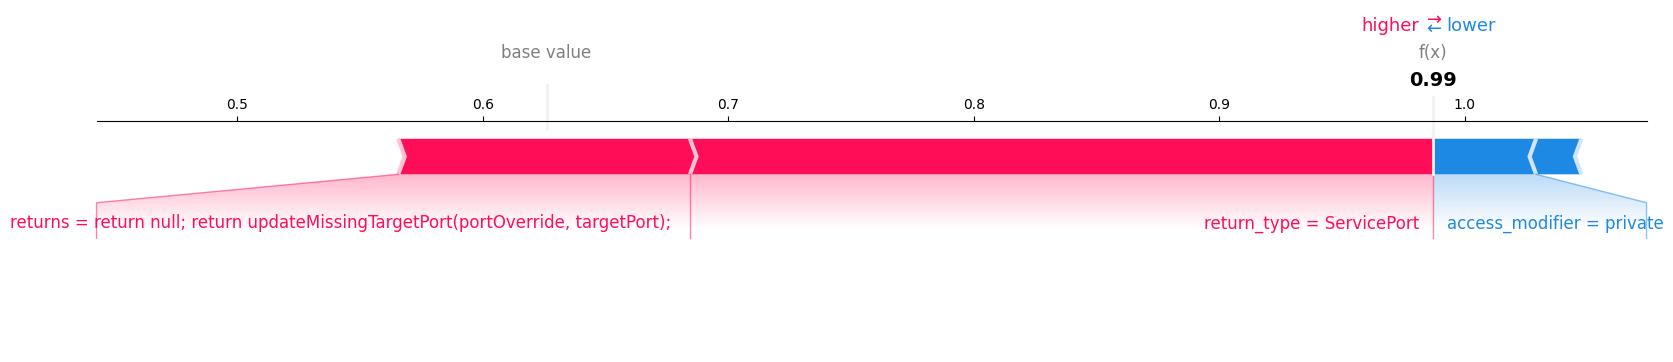



model/jkube_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is hawkbit
(0, 8)
access_modifier               public
return_type                     void
method_name        getErrorCondition
parameters                       NaN
returns                          NaN
catagory                         get
index                              1
Name: 1, dtype: object
processing train: 149003 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
19479  0.0  1.0     0.0  0.0
16032  0.0  1.0     0.0  0.0
42390  1.0  0.0     0.0  0.0
6209   1.0  0.0     0.0  0.0
62595  1.0  0.0     0.0  0.0
processing test: 16388 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
53631  0.0  0.0     1.0  0.0
13088  0.0  1.0     0.0  0.0
34801  0.0  0.0     1.0  0.0
42755  0.0  0.0     0.0  1.0
6364   0.0  0.0     1.0  0.0
Is Multi-Label?

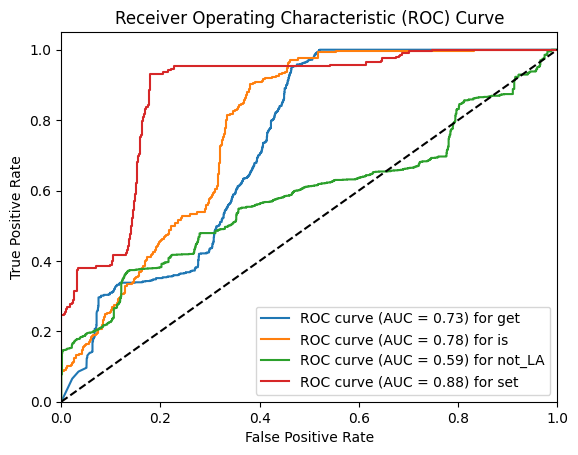

Class get:
y_true_class: 0       1
1       1
2       0
3       1
4       0
       ..
2647    0
2648    0
2649    0
2650    0
2651    1
Name: catagory, Length: 2652, dtype: int64
y_pred_class: [6.3202745e-01 6.3202703e-01 3.8845698e-08 ... 4.1117321e-05 9.7758704e-01
 5.5151010e-01]
AUC for class get: 0.7311258278145696
Class is:
y_true_class: 0       0
1       0
2       0
3       0
4       1
       ..
2647    0
2648    0
2649    0
2650    0
2651    0
Name: catagory, Length: 2652, dtype: int64
y_pred_class: [3.6612013e-01 3.6612055e-01 1.1143175e-05 ... 6.0186186e-04 2.2388246e-02
 4.4840124e-01]
AUC for class is: 0.7759174022932277
Class not_LA:
y_true_class: 0       0
1       0
2       0
3       0
4       0
       ..
2647    1
2648    1
2649    0
2650    1
2651    0
Name: catagory, Length: 2652, dtype: int64
y_pred_class: [1.7906144e-03 1.7905927e-03 5.5065844e-04 ... 9.4436508e-01 2.4644938e-05
 8.7790228e-05]
AUC for class not_LA: 0.5864430473389669
Class set:
y_true_class: 0       

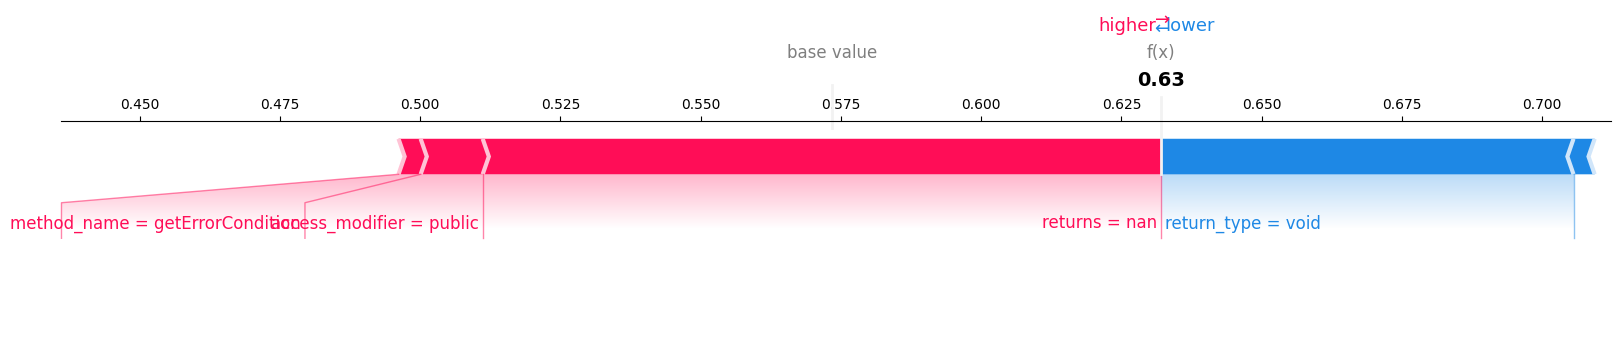



model/hawkbit_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  0.0  0.0     0.0  1.0
3  1.0  0.0     0.0  0.0
4  0.0  1.0     0.0  0.0
the project is kura
(0, 8)
access_modifier                            public
return_type                      NetInterfaceType
method_name                               getType
parameters                                    NaN
returns            return NetInterfaceType.WIFI; 
catagory                                   not_LA
index                                           1
Name: 1, dtype: object
processing train: 132267 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
77157  0.0  0.0     1.0  0.0
21654  0.0  1.0     0.0  0.0
71084  0.0  0.0     1.0  0.0
9472   1.0  0.0     0.0  0.0
249    0.0  0.0     1.0  0.0
processing test: 14513 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
305    1.0  0.0     0.0  0.0
26257  1.0  0.0     0.0  0.0
55158  0.0  0.

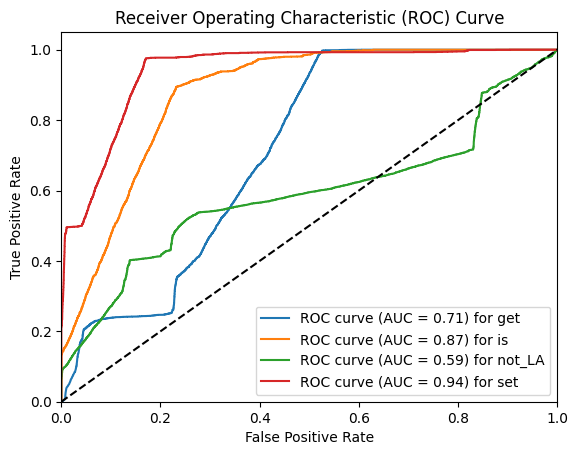

Class get:
y_true_class: 0        1
1        0
2        1
3        0
4        0
        ..
21258    0
21259    0
21260    0
21261    0
21262    0
Name: catagory, Length: 21263, dtype: int64
y_pred_class: [9.6948606e-01 9.9999964e-01 7.8759807e-01 ... 9.9982762e-01 7.4230796e-01
 3.8199720e-05]
AUC for class get: 0.7123433949102101
Class is:
y_true_class: 0        0
1        0
2        0
3        0
4        0
        ..
21258    1
21259    0
21260    0
21261    0
21262    0
Name: catagory, Length: 21263, dtype: int64
y_pred_class: [1.8509958e-02 2.7299747e-09 1.9875275e-01 ... 1.7219217e-04 2.5181100e-01
 8.2634164e-05]
AUC for class is: 0.8741557603200012
Class not_LA:
y_true_class: 0        0
1        1
2        0
3        1
4        1
        ..
21258    0
21259    1
21260    1
21261    1
21262    0
Name: catagory, Length: 21263, dtype: int64
y_pred_class: [1.1908397e-02 3.0470554e-07 1.3275092e-02 ... 7.8538186e-08 5.7207108e-03
 9.9002445e-01]
AUC for class not_LA: 0.58940680359373

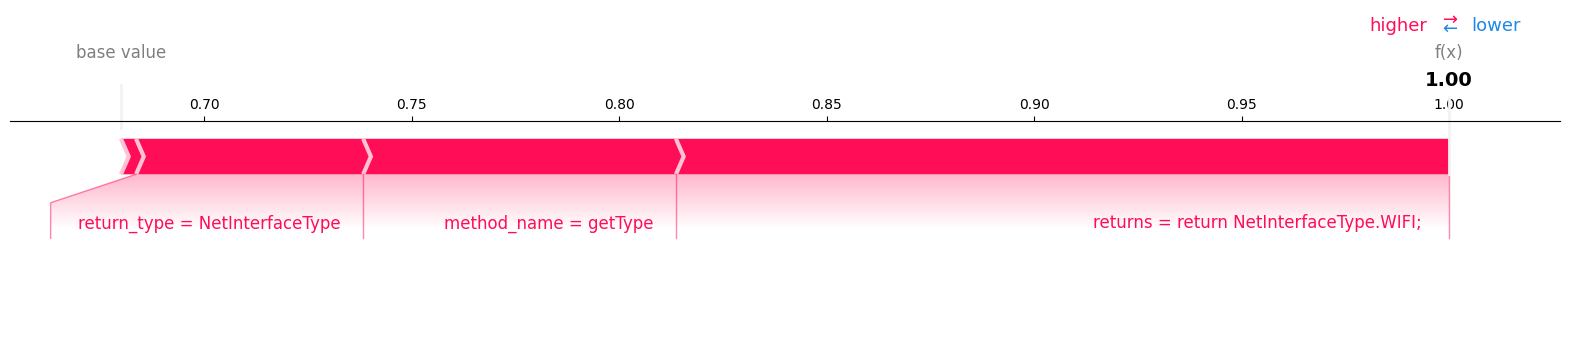



model/kura_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is milo
(0, 8)
access_modifier                                   public
return_type                             PropertyTypeNode
method_name                              getReqTimesNode
parameters                                           NaN
returns            return getReqTimesNodeAsync().get(); 
catagory                                          not_LA
index                                                  1
Name: 1, dtype: object
processing train: 140421 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
45114  0.0  0.0     1.0  0.0
93111  0.0  0.0     1.0  0.0
51200  1.0  0.0     0.0  0.0
61132  0.0  0.0     1.0  0.0
982    1.0  0.0     0.0  0.0
processing test: 15446 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
78219  1.0  0.0     0.0

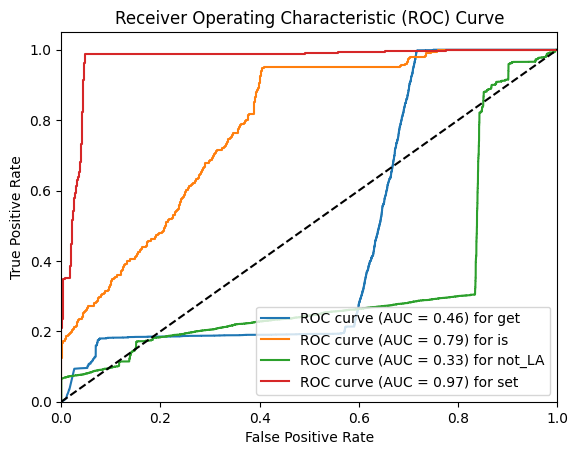

Class get:
y_true_class: 0        1
1        0
2        1
3        0
4        1
        ..
12171    1
12172    1
12173    1
12174    1
12175    1
Name: catagory, Length: 12176, dtype: int64
y_pred_class: [0.44446635 0.97484607 0.99999976 ... 0.41129744 0.4112947  0.99999905]
AUC for class get: 0.4616002801314012
Class is:
y_true_class: 0        0
1        0
2        0
3        0
4        0
        ..
12171    0
12172    0
12173    0
12174    0
12175    0
Name: catagory, Length: 12176, dtype: int64
y_pred_class: [5.5095840e-01 2.4429640e-02 2.1585667e-07 ... 5.8533424e-01 5.8533698e-01
 8.8407529e-07]
AUC for class is: 0.7863528916232626
Class not_LA:
y_true_class: 0        0
1        1
2        0
3        1
4        0
        ..
12171    0
12172    0
12173    0
12174    0
12175    0
Name: catagory, Length: 12176, dtype: int64
y_pred_class: [4.4581965e-03 7.1853225e-04 5.5987975e-10 ... 3.2927154e-03 3.2926351e-03
 7.8008476e-08]
AUC for class not_LA: 0.33242627858996415
Class set:
y_tr

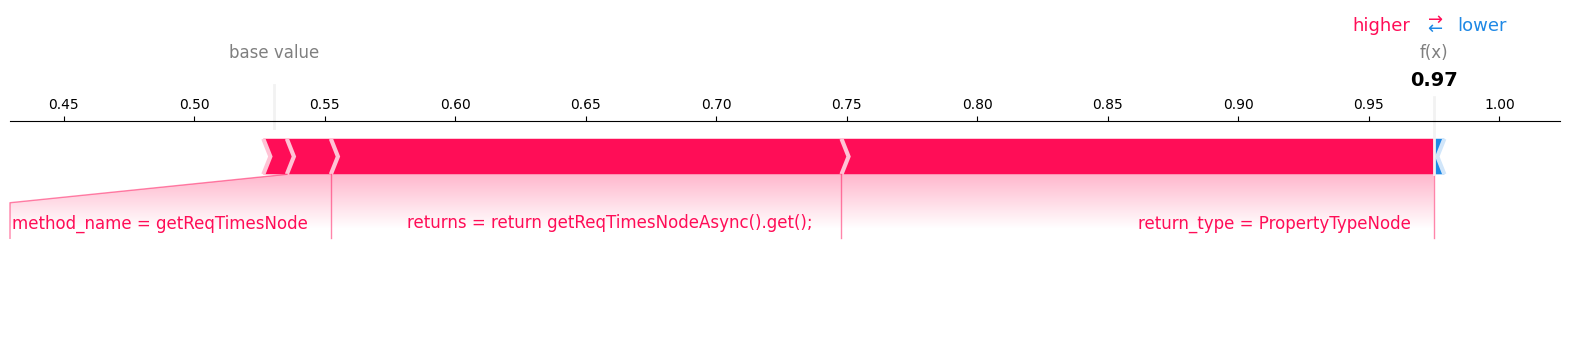



model/milo_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  1.0  0.0     0.0  0.0
the project is openvsx
(0, 8)
access_modifier                                            private
return_type                                        AdminStatistics
method_name                                              getReport
parameters                  String tokenValue, int year, int month
returns            return admins.getAdminStatistics(year, month); 
catagory                                                    not_LA
index                                                            1
Name: 1, dtype: object
processing train: 149027 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
5530   1.0  0.0     0.0  0.0
15594  1.0  0.0     0.0  0.0
81719  0.0  0.0     1.0  0.0
5696   1.0  0.0     0.0  0.0
91310  0.0  0.0     1.0  0.0
processing test: 16393 rows x 7 columns
['get', 'i

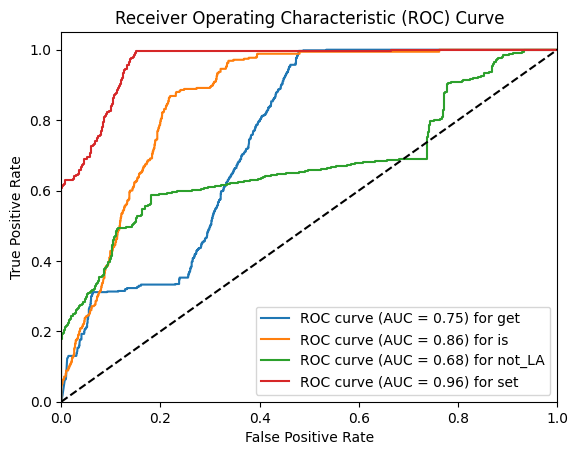

Class get:
y_true_class: 0       0
1       0
2       0
3       0
4       0
       ..
2618    1
2619    0
2620    0
2621    0
2622    0
Name: catagory, Length: 2623, dtype: int64
y_pred_class: [7.1760269e-06 9.9998140e-01 7.1752106e-06 ... 1.1326796e-06 9.8834038e-01
 1.3100062e-13]
AUC for class get: 0.7491223425119636
Class is:
y_true_class: 0       0
1       0
2       0
3       1
4       0
       ..
2618    0
2619    0
2620    1
2621    0
2622    0
Name: catagory, Length: 2623, dtype: int64
y_pred_class: [5.6865316e-05 5.7774528e-06 5.6860521e-05 ... 9.7794342e-01 1.0145067e-02
 2.7121376e-09]
AUC for class is: 0.8647998240211174
Class not_LA:
y_true_class: 0       1
1       1
2       0
3       0
4       1
       ..
2618    0
2619    1
2620    0
2621    1
2622    1
Name: catagory, Length: 2623, dtype: int64
y_pred_class: [9.9118525e-01 1.2833874e-05 9.9118584e-01 ... 2.2040606e-02 1.5050253e-03
 1.0000000e+00]
AUC for class not_LA: 0.6755159515030587
Class set:
y_true_class: 0       

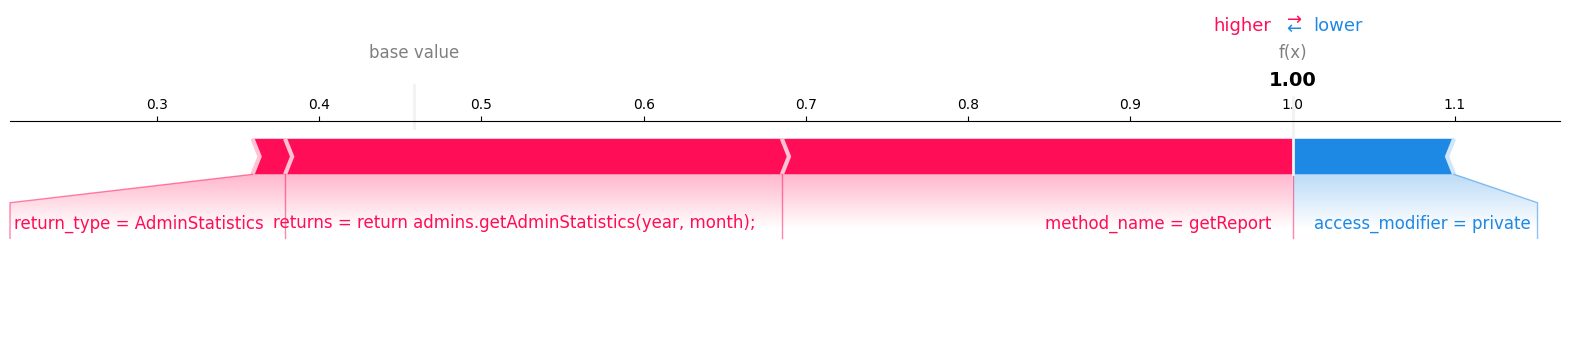



model/openvsx_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     0.0  1.0
3  0.0  1.0     0.0  0.0
4  0.0  0.0     1.0  0.0
the project is steady
(0, 8)
access_modifier              public
return_type                  String
method_name              getContext
parameters                      NaN
returns            return context; 
catagory                     not_LA
index                             1
Name: 1, dtype: object
processing train: 140937 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
12512  0.0  0.0     1.0  0.0
30283  1.0  0.0     0.0  0.0
22858  0.0  0.0     1.0  0.0
2097   0.0  0.0     1.0  0.0
10430  0.0  0.0     1.0  0.0
processing test: 15506 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
60646  0.0  0.0     1.0  0.0
9362   1.0  0.0     0.0  0.0
38371  0.0  0.0     1.0  0.0
1694   0.0  0.0     1.0  0.0
9512   0.0  0.0     1.0  0.0
Is Multi-Label? False
d

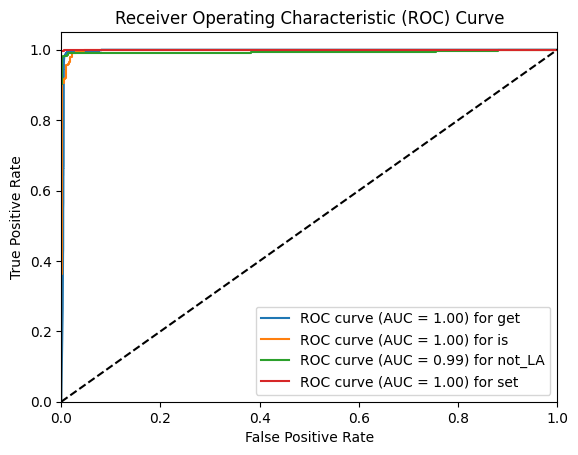

Class get:
y_true_class: 0        0
1        0
2        0
3        0
4        0
        ..
11595    0
11596    1
11597    1
11598    0
11599    0
Name: catagory, Length: 11600, dtype: int64
y_pred_class: [1.5002004e-05 0.0000000e+00 4.2285283e-27 ... 9.9999535e-01 4.9377481e-15
 3.9130167e-20]
AUC for class get: 0.9960351058321572
Class is:
y_true_class: 0        0
1        0
2        0
3        0
4        0
        ..
11595    0
11596    0
11597    0
11598    0
11599    0
Name: catagory, Length: 11600, dtype: int64
y_pred_class: [4.3087844e-06 5.6348875e-15 4.4484524e-10 ... 4.6063346e-06 1.5403673e-06
 4.9565291e-12]
AUC for class is: 0.9975832559580742
Class not_LA:
y_true_class: 0        1
1        1
2        1
3        0
4        1
        ..
11595    1
11596    0
11597    0
11598    1
11599    0
Name: catagory, Length: 11600, dtype: int64
y_pred_class: [9.999807e-01 1.000000e+00 1.000000e+00 ... 3.525069e-08 9.999970e-01
 9.873153e-08]
AUC for class not_LA: 0.9935126209327133
Cla

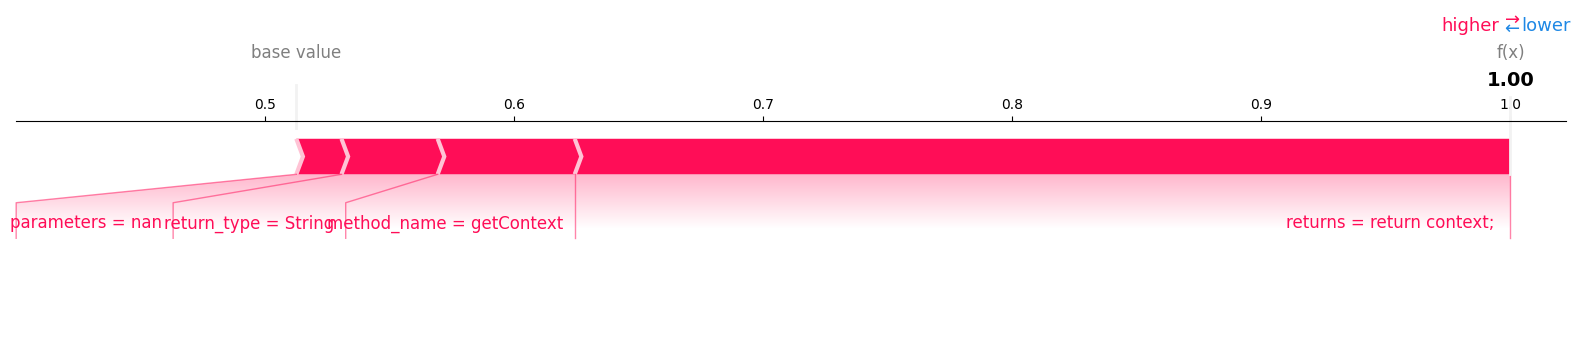



model/steady_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  0.0  0.0     1.0  0.0
the project is xtext
(0, 8)
access_modifier             public
return_type                   void
method_name        testRuleCall_01
parameters                     NaN
returns                        NaN
catagory                        is
index                            1
Name: 1, dtype: object
processing train: 62026 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9078   1.0  0.0     0.0  0.0
6208   0.0  1.0     0.0  0.0
1311   0.0  0.0     1.0  0.0
20792  1.0  0.0     0.0  0.0
5047   0.0  1.0     0.0  0.0
processing test: 6799 rows x 7 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
19799  1.0  0.0     0.0  0.0
6859   0.0  0.0     1.0  0.0
338    1.0  0.0     0.0  0.0
16503  0.0  1.0     0.0  0.0
3072   1.0  0.0     0.0  0.0
Is Multi-Label? False
done.


beg

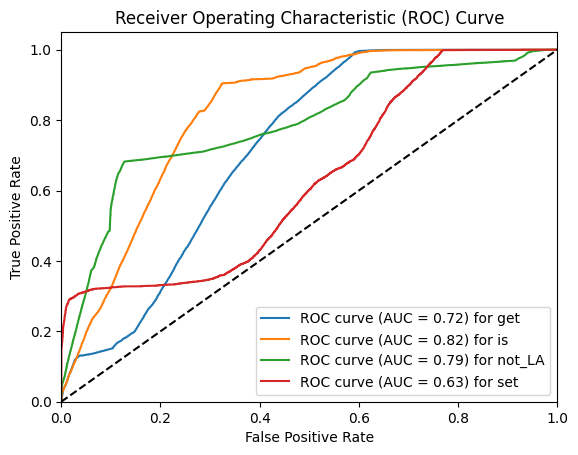

Class get:
y_true_class: 0        0
1        0
2        0
3        1
4        0
        ..
99213    0
99214    0
99215    1
99216    0
99217    0
Name: catagory, Length: 99218, dtype: int64
y_pred_class: [7.6793659e-01 5.8702809e-01 5.8703226e-01 ... 1.4061764e-03 5.3302801e-12
 8.2897051e-05]
AUC for class get: 0.7184078687075564
Class is:
y_true_class: 0        1
1        1
2        0
3        0
4        0
        ..
99213    0
99214    1
99215    0
99216    0
99217    0
Name: catagory, Length: 99218, dtype: int64
y_pred_class: [0.1886621  0.40164942 0.40164694 ... 0.73603934 0.04228091 0.3377891 ]
AUC for class is: 0.8220709804963109
Class not_LA:
y_true_class: 0        0
1        0
2        1
3        0
4        1
        ..
99213    1
99214    0
99215    0
99216    1
99217    1
Name: catagory, Length: 99218, dtype: int64
y_pred_class: [0.04115564 0.01038079 0.01037931 ... 0.24875772 0.95760834 0.6558198 ]
AUC for class not_LA: 0.7874279821627139
Class set:
y_true_class: 0        0

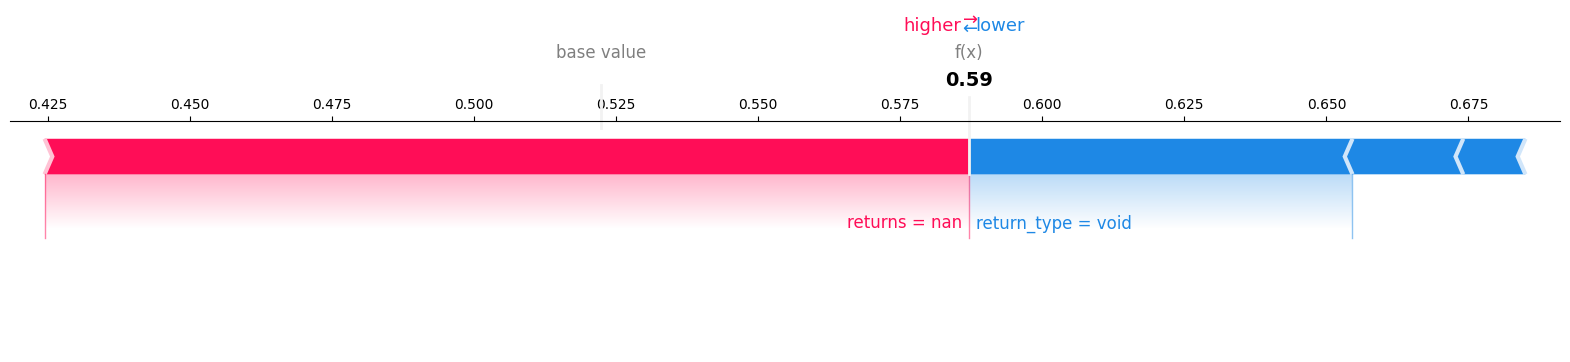



model/xtext_features_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  1.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  0.0     1.0  0.0
3  1.0  0.0     0.0  0.0
4  0.0  0.0     1.0  0.0


In [6]:
a = {
    "buildship": " ", 
    "eclips-collections": " ",
    "jifa": " ",
    "jkube": " ",
    "hawkbit": "https://github.com/eclipse/hawkbit.git",
    "kura": "https://github.com/eclipse/kura.git",
    "milo": "https://github.com/eclipse/milo.git",
    "openvsx": "https://github.com/eclipse/openvsx.git",
    "steady": "https://github.com/eclipse/steady.git",
    "xtext": "https://github.com/eclipse/xtext.git"
}
for project,url in a.items():
    print(f"the project is {project}")
    train_df,test_df = get_model(a,project)
    predictor = get_lean(train_df,test_df)
    model_save(predictor,test_df,project)